In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Kaggle 데이터 로드
wine_df = pd.read_csv('./winequality-red.csv')

print(f"총 와인 샘플: {len(wine_df)}개")
print(f"특성 개수: {len(wine_df.columns)-1}개")
print(f"품질 범위: {wine_df['quality'].min()}점 ~ {wine_df['quality'].max()}점")
print("\n📊 데이터 미리보기:")
wine_df.head()


총 와인 샘플: 1599개
특성 개수: 11개
품질 범위: 3점 ~ 8점

📊 데이터 미리보기:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


  fixed acidity       : 고정 산도 - 와인의 신맛과 보존성
  volatile acidity    : 휘발성 산도 - 식초 맛, 높으면 불쾌한 냄새
  citric acid         : 구연산 - 신선함과 과일 향
  residual sugar      : 잔당 - 단맛의 정도
  chlorides           : 염분 - 짠맛
  free sulfur dioxide : 자유 이산화황 - 산화 방지
  total sulfur dioxide: 총 이산화황 - 보존제
  density             : 밀도 - 당분과 알코올에 영향
  pH                  : 산성도 - 3-4가 이상적
  sulphates           : 황산염 - 항산화제, 품질 향상
  alcohol             : 알코올 도수 - 맛과 보디감


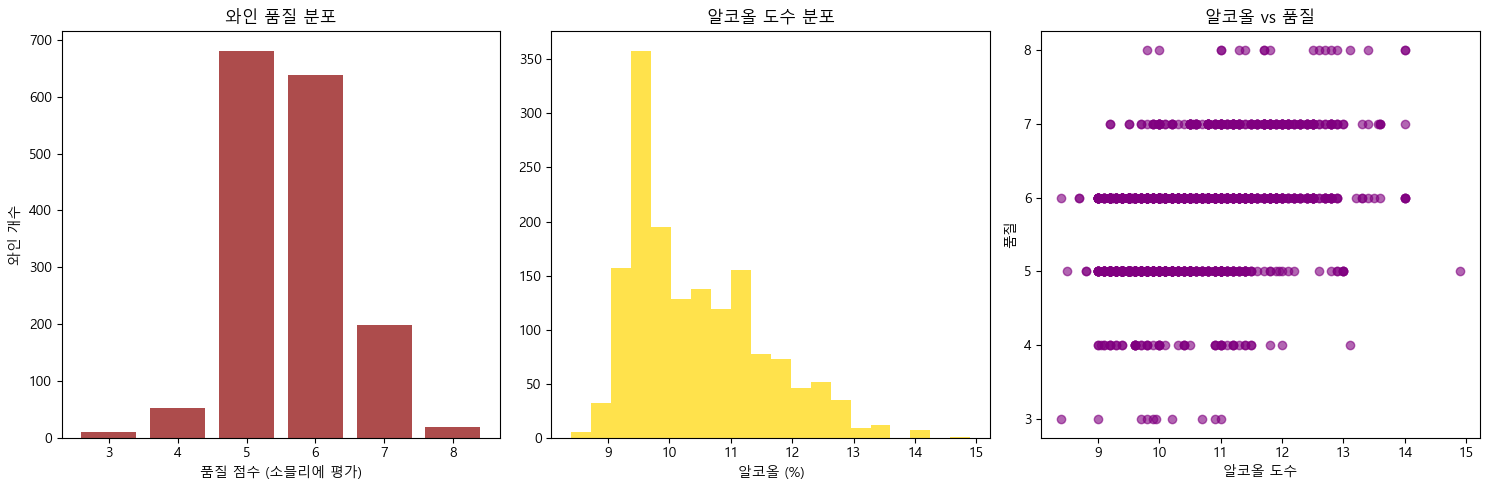


💡 발견:
  • 대부분 와인이 5-6점 (보통 품질)
  • 알코올 도수는 8-15% 범위
  • 고급 와인 (8-9점)은 희귀!


In [7]:
features_explanation = {
    'fixed acidity': '고정 산도 - 와인의 신맛과 보존성',
    'volatile acidity': '휘발성 산도 - 식초 맛, 높으면 불쾌한 냄새',
    'citric acid': '구연산 - 신선함과 과일 향',
    'residual sugar': '잔당 - 단맛의 정도',
    'chlorides': '염분 - 짠맛',
    'free sulfur dioxide': '자유 이산화황 - 산화 방지',
    'total sulfur dioxide': '총 이산화황 - 보존제',
    'density': '밀도 - 당분과 알코올에 영향',
    'pH': '산성도 - 3-4가 이상적',
    'sulphates': '황산염 - 항산화제, 품질 향상',
    'alcohol': '알코올 도수 - 맛과 보디감'
}

for feature, explanation in features_explanation.items():
    print(f"  {feature:20s}: {explanation}")

# 와인 품질 분포 - 소믈리에들의 평가!
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
quality_counts = wine_df['quality'].value_counts().sort_index()
plt.bar(quality_counts.index, quality_counts.values, color='darkred', alpha=0.7)
plt.title('와인 품질 분포')
plt.xlabel('품질 점수 (소믈리에 평가)')
plt.ylabel('와인 개수')

plt.subplot(1, 3, 2)
plt.hist(wine_df['alcohol'], bins=20, color='gold', alpha=0.7)
plt.title('알코올 도수 분포')
plt.xlabel('알코올 (%)')

plt.subplot(1, 3, 3)
plt.scatter(wine_df['alcohol'], wine_df['quality'], alpha=0.6, color='purple')
plt.title('알코올 vs 품질')
plt.xlabel('알코올 도수')
plt.ylabel('품질')

plt.tight_layout()
plt.show()

print(f"\n💡 발견:")
print(f"  • 대부분 와인이 5-6점 (보통 품질)")
print(f"  • 알코올 도수는 8-15% 범위")
print(f"  • 고급 와인 (8-9점)은 희귀!")


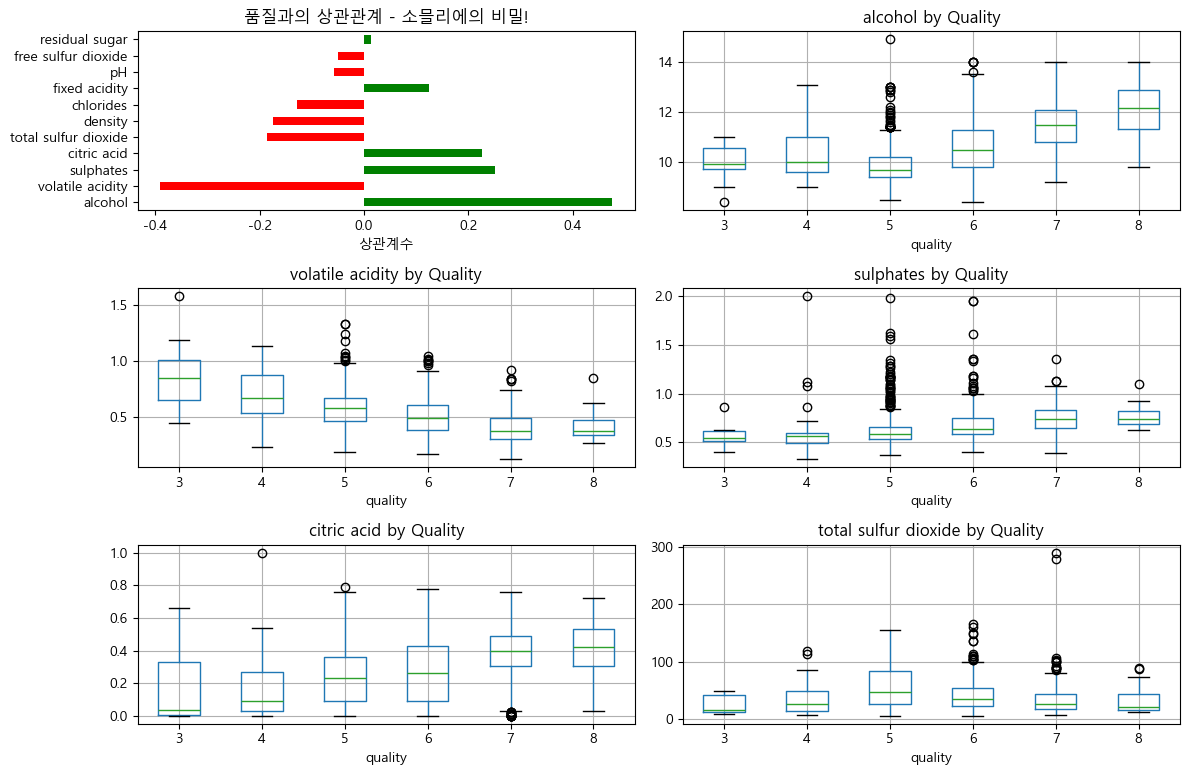

상관관계 순위:
 1. alcohol             :  0.476
 2. volatile acidity    : -0.391
 3. sulphates           :  0.251
 4. citric acid         :  0.226
 5. total sulfur dioxide: -0.185
 6. density             : -0.175
 7. chlorides           : -0.129
 8. fixed acidity       :  0.124
 9. pH                  : -0.058
10. free sulfur dioxide : -0.051
11. residual sugar      :  0.014


In [16]:
# 품질과 가장 관련 높은 특성들 찾기

correlations = wine_df.corr()['quality'].drop('quality').sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.title('품질과의 상관관계 - 소믈리에의 비밀!')
plt.xlabel('상관계수')

# 상위 특성들의 품질별 분포
plt.subplot(3, 2, 2)
top_features = correlations.abs().head(5).index
for i, feature in enumerate(top_features):
    plt.subplot(3, 2, i+2)
    wine_df.boxplot(column=feature, by='quality', ax=plt.gca())
    plt.title(f'{feature} by Quality')
    plt.suptitle('')

plt.tight_layout()
plt.show()

print("상관관계 순위:")
for i, (feature, corr) in enumerate(correlations.items(), 1):
    print(f"{i:2d}. {feature:20s}: {corr:6.3f}")


In [18]:
print("🎯 미션 선택의 시간!")
print("\n옵션 1: 회귀 문제 - 정확한 품질 점수 예측")
print("  • 목표: 5.6점, 6.2점 같은 연속적 점수")
print("  • 평가: R² Score, RMSE")
print("  • 장점: 세밀한 예측 가능")

print("\n옵션 2: 분류 문제 - 품질 등급 분류")
print("  • 목표: 저품질(3-5점), 보통(6점), 고품질(7-9점)")
print("  • 평가: Accuracy, F1-Score") 
print("  • 장점: 비즈니스에서 더 실용적")

print("\n🚀 우리의 선택: 둘 다 해보자!")

# 분류를 위한 타겟 생성
def categorize_wine_quality(quality):
    if quality <= 5:
        return 0  # 저품질
    elif quality == 6:
        return 1  # 보통품질  
    else:
        return 2  # 고품질

wine_df['quality_category'] = wine_df['quality'].apply(categorize_wine_quality)
quality_labels = {0: '저품질 (3-5점)', 1: '보통품질 (6점)', 2: '고품질 (7-9점)'}

print("\n🏷️ 품질 카테고리 분포:")
category_counts = wine_df['quality_category'].value_counts().sort_index()
for cat, count in category_counts.items():
    print(f"  {quality_labels[cat]}: {count}개 ({count/len(wine_df)*100:.1f}%)")

# 데이터 준비
X = wine_df.drop(['quality', 'quality_category'], axis=1)
y_regression = wine_df['quality']  # 회귀용
y_classification = wine_df['quality_category']  # 분류용

print(f"\n✅ 데이터 준비 완료!")
print(f"특성 개수: {len(X.columns)}")
print(f"샘플 수: {len(X)}")

🎯 미션 선택의 시간!

옵션 1: 회귀 문제 - 정확한 품질 점수 예측
  • 목표: 5.6점, 6.2점 같은 연속적 점수
  • 평가: R² Score, RMSE
  • 장점: 세밀한 예측 가능

옵션 2: 분류 문제 - 품질 등급 분류
  • 목표: 저품질(3-5점), 보통(6점), 고품질(7-9점)
  • 평가: Accuracy, F1-Score
  • 장점: 비즈니스에서 더 실용적

🚀 우리의 선택: 둘 다 해보자!

🏷️ 품질 카테고리 분포:
  저품질 (3-5점): 744개 (46.5%)
  보통품질 (6점): 638개 (39.9%)
  고품질 (7-9점): 217개 (13.6%)

✅ 데이터 준비 완료!
특성 개수: 11
샘플 수: 1599


In [19]:
# 데이터 분할 (회귀)
X_train, X_val, y_reg_train, y_reg_val = train_test_split(
    X, y_regression, test_size=0.2, random_state=42)

# 분류용도 같은 방식으로 분할
_, _, y_cls_train, y_cls_val = train_test_split(
    X, y_classification, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"🔄 데이터 분할 완료!")
print(f"훈련: {len(X_train)} | 검증: {len(X_val)}")


🔄 데이터 분할 완료!
훈련: 1279 | 검증: 320


In [22]:
regression_results = {}

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_reg_train)
lr_score = lr_model.score(X_val_scaled, y_reg_val)
lr_pred = lr_model.predict(X_val_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_reg_val, lr_pred))
regression_results['Linear Regression'] = {'r2': lr_score, 'rmse': lr_rmse}

# 2. Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_reg_train)
ridge_score = ridge_model.score(X_val_scaled, y_reg_val)
ridge_pred = ridge_model.predict(X_val_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_reg_val, ridge_pred))
regression_results['Ridge'] = {'r2': ridge_score, 'rmse': ridge_rmse}

# 3. Lasso Regression  
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_reg_train)
lasso_score = lasso_model.score(X_val_scaled, y_reg_val)
lasso_pred = lasso_model.predict(X_val_scaled)
lasso_rmse = np.sqrt(mean_squared_error(y_reg_val, lasso_pred))
regression_results['Lasso'] = {'r2': lasso_score, 'rmse': lasso_rmse}

# 4. Polynomial Features + Ridge
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

poly_ridge = Ridge(alpha=10.0)  # 더 강한 규제
poly_ridge.fit(X_train_poly, y_reg_train)
poly_score = poly_ridge.score(X_val_poly, y_reg_val)
poly_pred = poly_ridge.predict(X_val_poly)
poly_rmse = np.sqrt(mean_squared_error(y_reg_val, poly_pred))
regression_results['Polynomial Ridge'] = {'r2': poly_score, 'rmse': poly_rmse}

for model, scores in regression_results.items():
    print(f"  {model:18s}: R²={scores['r2']:.4f}, RMSE={scores['rmse']:.4f}")

print(f"특성 수 변화: {X_train_scaled.shape[1]} → {X_train_poly.shape[1]} (다항식)")


  Linear Regression : R²=0.4032, RMSE=0.6245
  Ridge             : R²=0.4032, RMSE=0.6245
  Lasso             : R²=0.3986, RMSE=0.6269
  Polynomial Ridge  : R²=0.4299, RMSE=0.6104
특성 수 변화: 11 → 66 (다항식)


In [23]:

# KNN with Cross Validation
k_range = [3, 5, 7, 10, 15, 20]
knn_cv_scores = []

for k in k_range:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, X_train_scaled, y_reg_train, cv=5, scoring='r2')
    knn_cv_scores.append(cv_scores.mean())
    print(f"  KNN (K={k:2d}): CV R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

best_k = k_range[np.argmax(knn_cv_scores)]
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_reg_train)
knn_score = knn_best.score(X_val_scaled, y_reg_val)
knn_pred = knn_best.predict(X_val_scaled)
knn_rmse = np.sqrt(mean_squared_error(y_reg_val, knn_pred))
regression_results[f'KNN (K={best_k})'] = {'r2': knn_score, 'rmse': knn_rmse}

print(f"\n🏆 최적 KNN: K={best_k}, R²={knn_score:.4f}, RMSE={knn_rmse:.4f}")


  KNN (K= 3): CV R² = 0.2008 (±0.0427)
  KNN (K= 5): CV R² = 0.2418 (±0.0478)
  KNN (K= 7): CV R² = 0.2591 (±0.0443)
  KNN (K=10): CV R² = 0.2745 (±0.0602)
  KNN (K=15): CV R² = 0.2918 (±0.0607)
  KNN (K=20): CV R² = 0.3003 (±0.0630)

🏆 최적 KNN: K=20, R²=0.3744, RMSE=0.6394


In [24]:

# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=8, random_state=42)
dt_model.fit(X_train, y_reg_train)  # 스케일링 불필요
dt_score = dt_model.score(X_val, y_reg_val)
dt_pred = dt_model.predict(X_val)
dt_rmse = np.sqrt(mean_squared_error(y_reg_val, dt_pred))
regression_results['Decision Tree'] = {'r2': dt_score, 'rmse': dt_rmse}

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_train, y_reg_train)
rf_score = rf_model.score(X_val, y_reg_val)
rf_pred = rf_model.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_reg_val, rf_pred))
regression_results['Random Forest'] = {'r2': rf_score, 'rmse': rf_rmse}

# Extra Trees
et_model = ExtraTreesRegressor(n_estimators=100, max_depth=8, random_state=42)
et_model.fit(X_train, y_reg_train)
et_score = et_model.score(X_val, y_reg_val)
et_pred = et_model.predict(X_val)
et_rmse = np.sqrt(mean_squared_error(y_reg_val, et_pred))
regression_results['Extra Trees'] = {'r2': et_score, 'rmse': et_rmse}

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
gb_model.fit(X_train, y_reg_train)
gb_score = gb_model.score(X_val, y_reg_val)
gb_pred = gb_model.predict(X_val)
gb_rmse = np.sqrt(mean_squared_error(y_reg_val, gb_pred))
regression_results['Gradient Boosting'] = {'r2': gb_score, 'rmse': gb_rmse}

tree_models = ['Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting']
for model in tree_models:
    scores = regression_results[model]
    print(f"  {model:18s}: R²={scores['r2']:.4f}, RMSE={scores['rmse']:.4f}")


  Decision Tree     : R²=0.1868, RMSE=0.7290
  Random Forest     : R²=0.4949, RMSE=0.5746
  Extra Trees       : R²=0.4824, RMSE=0.5816
  Gradient Boosting : R²=0.4700, RMSE=0.5885


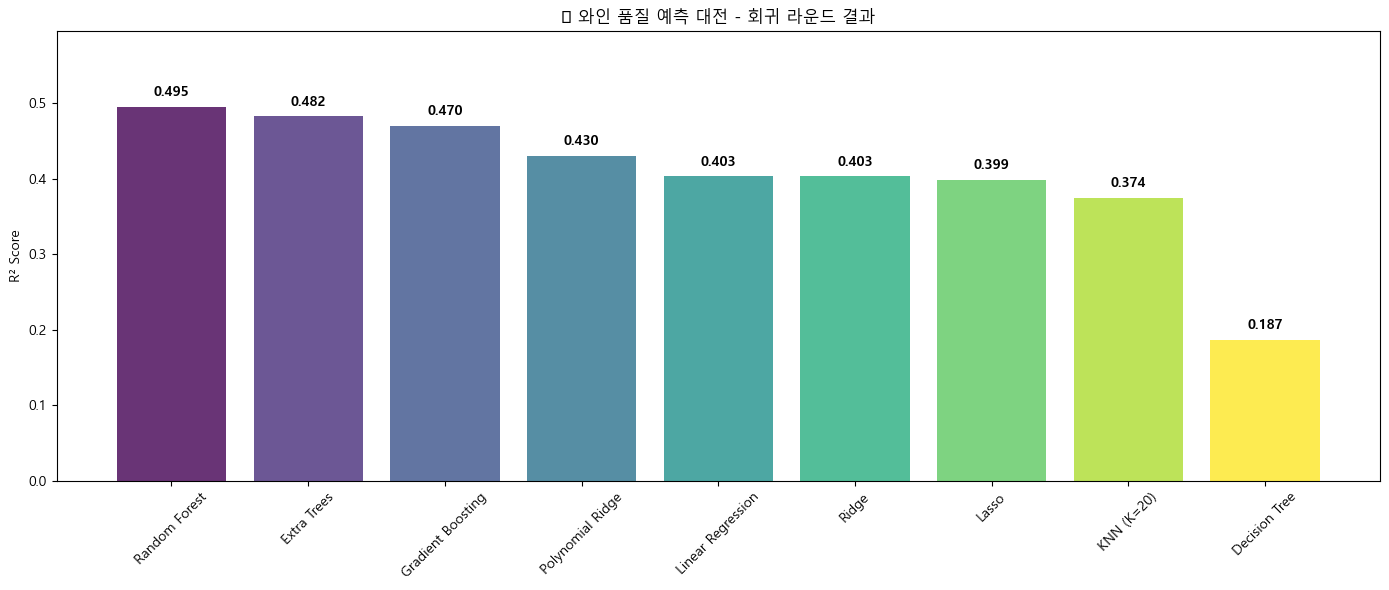


🥇 회귀 라운드 우승자: Random Forest
🏆 최고 성능: R² = 0.4949
🎯 해석: 품질 변동의 49.5%를 설명 가능!
✅ 괜찮은 성능! 경향성 파악에 유용


In [25]:
# 회귀 결과 정렬 및 시각화
regression_sorted = dict(sorted(regression_results.items(), 
                                key=lambda x: x[1]['r2'], reverse=True))

plt.figure(figsize=(14, 6))
models = list(regression_sorted.keys())
r2_scores = [regression_sorted[model]['r2'] for model in models]
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars = plt.bar(models, r2_scores, color=colors, alpha=0.8)
plt.title('🍷 와인 품질 예측 대전 - 회귀 라운드 결과')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.ylim(0, max(r2_scores) + 0.1)

for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 승자 발표
regression_winner = models[0]
winner_score = r2_scores[0]
print(f"\n🥇 회귀 라운드 우승자: {regression_winner}")
print(f"🏆 최고 성능: R² = {winner_score:.4f}")
print(f"🎯 해석: 품질 변동의 {winner_score*100:.1f}%를 설명 가능!")

if winner_score > 0.6:
    print("✅ 훌륭한 성능! 실무에서 충분히 활용 가능")
elif winner_score > 0.4:
    print("✅ 괜찮은 성능! 경향성 파악에 유용")
else:
    print("🤔 아직 개선 여지가 있어요")


In [27]:
classification_results = {}

# KNN Classification
knn_cls = KNeighborsClassifier(n_neighbors=best_k)
knn_cls.fit(X_train_scaled, y_cls_train)
knn_cls_score = knn_cls.score(X_val_scaled, y_cls_val)
classification_results[f'KNN (K={best_k})'] = knn_cls_score

# Logistic Regression
lr_cls = LogisticRegression(random_state=42, max_iter=1000)
lr_cls.fit(X_train_scaled, y_cls_train)
lr_cls_score = lr_cls.score(X_val_scaled, y_cls_val)
classification_results['Logistic Regression'] = lr_cls_score

# Polynomial Logistic Regression
poly_lr_cls = LogisticRegression(random_state=42, max_iter=1000)
poly_lr_cls.fit(X_train_poly, y_cls_train)
poly_lr_score = poly_lr_cls.score(X_val_poly, y_cls_val)
classification_results['Polynomial Logistic'] = poly_lr_score

# Decision Tree Classification
dt_cls = DecisionTreeClassifier(max_depth=8, random_state=42)
dt_cls.fit(X_train, y_cls_train)
dt_cls_score = dt_cls.score(X_val, y_cls_val)
classification_results['Decision Tree'] = dt_cls_score

# Random Forest Classification
rf_cls = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf_cls.fit(X_train, y_cls_train)
rf_cls_score = rf_cls.score(X_val, y_cls_val)
classification_results['Random Forest'] = rf_cls_score

# Extra Trees Classification
et_cls = ExtraTreesClassifier(n_estimators=100, max_depth=8, random_state=42)
et_cls.fit(X_train, y_cls_train)
et_cls_score = et_cls.score(X_val, y_cls_val)
classification_results['Extra Trees'] = et_cls_score

# Gradient Boosting Classification
gb_cls = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42)
gb_cls.fit(X_train, y_cls_train)
gb_cls_score = gb_cls.score(X_val, y_cls_val)
classification_results['Gradient Boosting'] = gb_cls_score

print("📊 분류 라운드 결과:")
for model, score in classification_results.items():
    print(f"  {model:20s}: 정확도 = {score:.4f}")


📊 분류 라운드 결과:
  KNN (K=20)          : 정확도 = 0.5844
  Logistic Regression : 정확도 = 0.6250
  Polynomial Logistic : 정확도 = 0.6219
  Decision Tree       : 정확도 = 0.6250
  Random Forest       : 정확도 = 0.6562
  Extra Trees         : 정확도 = 0.6438
  Gradient Boosting   : 정확도 = 0.6687


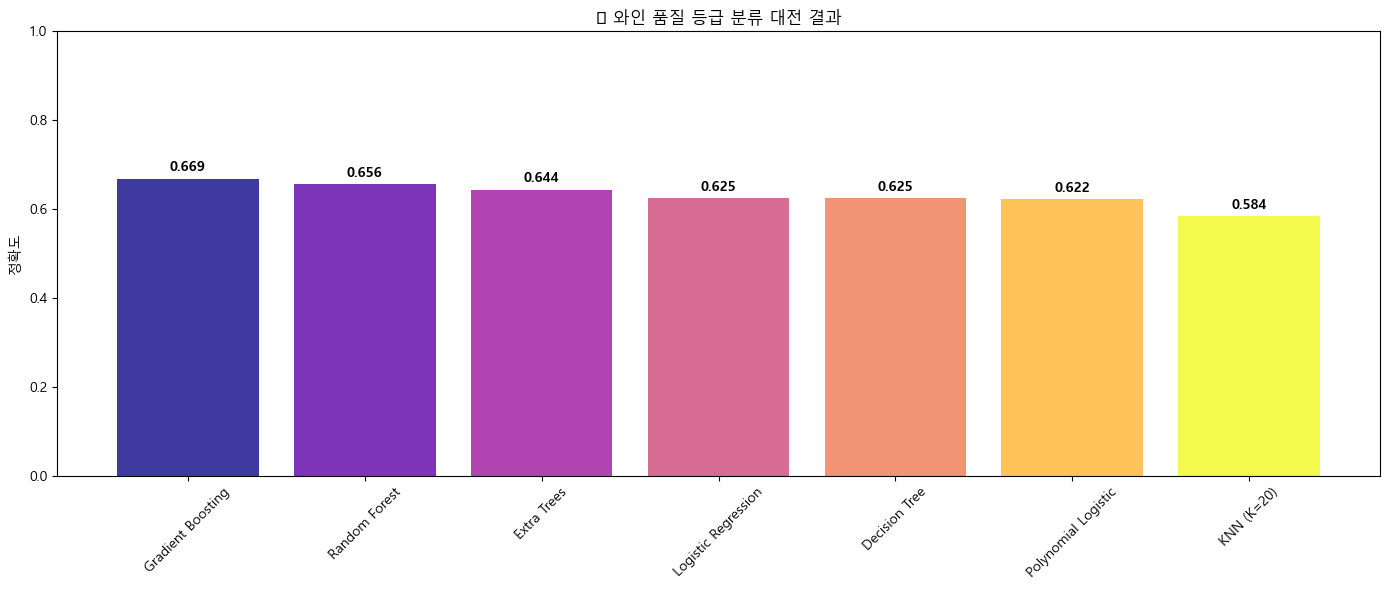


🥇 분류 라운드 우승자: Gradient Boosting
🏆 최고 정확도: 0.6687


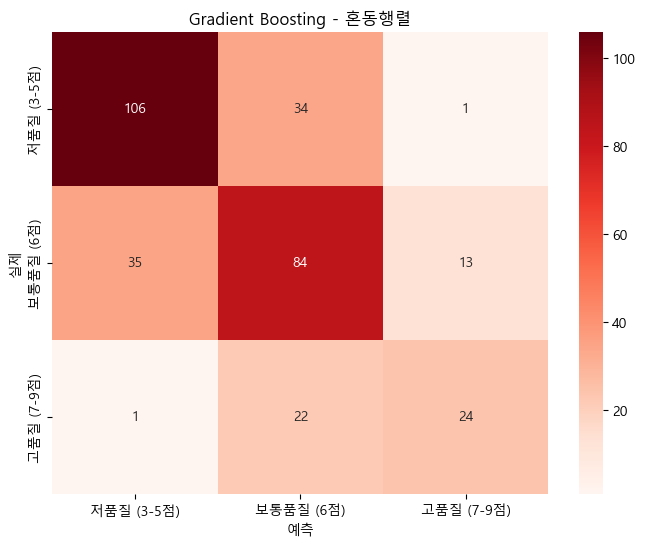


📊 등급별 예측 성능:
  저품질 (3-5점)     : 0.752 (106/141)
  보통품질 (6점)      : 0.636 (84/132)
  고품질 (7-9점)     : 0.511 (24/47)


In [28]:
# 분류 결과 시각화
classification_sorted = dict(sorted(classification_results.items(), 
                                   key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 6))
models = list(classification_sorted.keys())
acc_scores = list(classification_sorted.values())
colors = plt.cm.plasma(np.linspace(0, 1, len(models)))

bars = plt.bar(models, acc_scores, color=colors, alpha=0.8)
plt.title('🍷 와인 품질 등급 분류 대전 결과')
plt.ylabel('정확도')
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar, score in zip(bars, acc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 분류 우승자 상세 분석
classification_winner = models[0]
winner_cls_score = acc_scores[0]

print(f"\n🥇 분류 라운드 우승자: {classification_winner}")
print(f"🏆 최고 정확도: {winner_cls_score:.4f}")

# 최고 모델의 혼동행렬
if 'Random Forest' in classification_winner:
    best_cls_model = rf_cls
elif 'Gradient Boosting' in classification_winner:
    best_cls_model = gb_cls
elif 'Extra Trees' in classification_winner:
    best_cls_model = et_cls
elif 'KNN' in classification_winner:
    best_cls_model = knn_cls
elif 'Logistic' in classification_winner:
    best_cls_model = lr_cls if 'Polynomial' not in classification_winner else poly_lr_cls
else:
    best_cls_model = dt_cls

# 예측 및 혼동행렬
if 'KNN' in classification_winner or 'Logistic' in classification_winner:
    if 'Polynomial' in classification_winner:
        y_cls_pred = best_cls_model.predict(X_val_poly)
    else:
        y_cls_pred = best_cls_model.predict(X_val_scaled)
else:
    y_cls_pred = best_cls_model.predict(X_val)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_cls_val, y_cls_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=[quality_labels[i] for i in range(3)],
            yticklabels=[quality_labels[i] for i in range(3)])
plt.title(f'{classification_winner} - 혼동행렬')
plt.xlabel('예측')
plt.ylabel('실제')
plt.show()

# 각 등급별 정확도
print("\n📊 등급별 예측 성능:")
for i in range(3):
    mask = (y_cls_val == i)
    if mask.sum() > 0:
        correct = (y_cls_pred[mask] == i).sum()
        total = mask.sum()
        accuracy = correct / total
        print(f"  {quality_labels[i]:15s}: {accuracy:.3f} ({correct}/{total})")


In [31]:
# 회귀와 분류 우승자 튜닝
regression_winner_model = regression_winner
classification_winner_model = classification_winner

print(f"🎯 회귀 우승자: {regression_winner_model}")
print(f"🎯 분류 우승자: {classification_winner_model}")

# Random Forest 튜닝 (일반적으로 우승 가능성 높음)
if 'Random Forest' in regression_winner_model:
    param_grid_reg = {
        'n_estimators': [50, 100, 200],
        'max_depth': [6, 8, 10, 12],
        'min_samples_split': [2, 5, 10]
    }
    
    grid_search_reg = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid_reg,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_reg.fit(X_train, y_reg_train)
    
    print(f"✅ 최적 파라미터: {grid_search_reg.best_params_}")
    print(f"✅ 최적 CV 점수: {grid_search_reg.best_score_:.4f}")
    
    tuned_reg_score = grid_search_reg.score(X_val, y_reg_val)
    print(f"✅ 튜닝 후 검증 점수: {tuned_reg_score:.4f}")
    print(f"🚀 성능 향상: {tuned_reg_score - regression_results[regression_winner]['r2']:+.4f}")

# 분류도 같은 방식으로 튜닝
if 'Gradient Boosting' in classification_winner_model:
    param_grid_cls = {
        'n_estimators': [50, 100, 200],
        'max_depth': [6, 8, 10],
        'min_samples_split': [2, 5]
    }
    
    grid_search_cls = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid_cls,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search_cls.fit(X_train, y_cls_train)
    
    print(f"✅ 최적 파라미터: {grid_search_cls.best_params_}")
    print(f"✅ 최적 CV 점수: {grid_search_cls.best_score_:.4f}")
    
    tuned_cls_score = grid_search_cls.score(X_val, y_cls_val)
    print(f"✅ 튜닝 후 검증 점수: {tuned_cls_score:.4f}")
    print(f"🚀 성능 향상: {tuned_cls_score - classification_results[classification_winner]:+.4f}")


🎯 회귀 우승자: Random Forest
🎯 분류 우승자: Gradient Boosting
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ 최적 파라미터: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 200}
✅ 최적 CV 점수: 0.4242
✅ 튜닝 후 검증 점수: 0.5222
🚀 성능 향상: +0.0273
✅ 최적 파라미터: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 50}
✅ 최적 CV 점수: 0.7178
✅ 튜닝 후 검증 점수: 0.6750
🚀 성능 향상: +0.0063


In [ ]:
print("\n" + "="*60)
print("🔬 와인과학자의 발견: 품질에 가장 중요한 요소들")
print("="*60)

# 최고 모델의 특성 중요도 (트리 기반 모델인 경우)
if 'Random Forest' in regression_winner or 'Gradient Boosting' in regression_winner:
    if 'Random Forest' in regression_winner:
        model_for_importance = rf_model
    else:
        model_for_importance = gb_model
    
    importances = model_for_importance.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
             color='darkred', alpha=0.7)
    plt.title('와인 품질에 가장 중요한 화학적 특성들')
    plt.xlabel('중요도')
    
    # 상위 5개 특성의 품질별 분포
    top_5_features = feature_importance_df.head(5)['feature'].tolist()
    
    plt.subplot(2, 1, 2)
    for i, feature in enumerate(top_5_features[:3]):
        plt.subplot(2, 3, i+4)
        wine_df.boxplot(column=feature, by='quality', ax=plt.gca())
        plt.title(f'{feature}')
        plt.suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    print("🏆 와인 품질에 가장 중요한 특성 TOP 5:")
    for i, row in top_5_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        explanation = features_explanation.get(feature, "")
        print(f"  {i+1}. {feature:20s}: {importance:.3f} - {explanation}")

# 와인 추천 시스템 맛보기
print(f"\n🎯 AI 소믈리에의 와인 추천:")
print("완벽한 와인의 특성을 예측해보겠습니다!")

if 'Random Forest' in regression_winner:
    perfect_wine_features = X.mean()  # 평균적인 와인에서 시작
    
    # 중요한 특성들을 조정해서 품질 향상
    if 'alcohol' in top_5_features:
        perfect_wine_features['alcohol'] = wine_df['alcohol'].quantile(0.8)
    if 'sulphates' in top_5_features:
        perfect_wine_features['sulphates'] = wine_df['sulphates'].quantile(0.8)
    if 'volatile acidity' in top_5_features:
        perfect_wine_features['volatile acidity'] = wine_df['volatile acidity'].quantile(0.2)
    
    predicted_quality = rf_model.predict([perfect_wine_features])[0]
    print(f"AI가 설계한 완벽한 와인의 예상 품질: {predicted_quality:.2f}점")
    
    if predicted_quality >= 7:
        print("🍷 프리미엄급 와인이 탄생했습니다!")
    elif predicted_quality >= 6:
        print("🍷 좋은 품질의 와인입니다!")
    else:
        print("🍷 아직 개선의 여지가 있는 와인이네요.")
